In [1]:
import pickle
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
with open("mags.p", "rb") as f:
    data = pickle.load(f)

In [3]:
len(data)

2000000

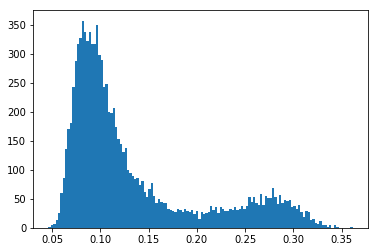

In [50]:
plt.hist(data[:10000], bins=128)
plt.show()

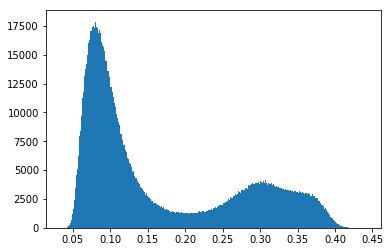

In [5]:
plt.hist(data, bins=512)
plt.show()

In [51]:
preX = np.random.choice(data[:5000], size=(100000, 100))
min_mag = min(data[:5000])
max_mag = max(data[:5000])
range_mag = max_mag - min_mag
min_mag -= 0.05*range_mag
max_mag += 0.05*range_mag
bins = np.linspace(min_mag, max_mag, 128)
mags = (bins[1:] + bins[:-1]) / 2
X = [np.histogram(x, bins=bins)[0] for x in preX]
X = np.array([x/max(x) for x in X])

In [52]:
class RBM():
    def __init__(self, nv=len(X[0]), nh=128, cd_steps=3):
        self.graph = tf.Graph() 
        with self.graph.as_default(): 
            self.W = tf.Variable(tf.truncated_normal((nv, nh)) * 0.01)
            self.bv = tf.Variable(tf.zeros((nv, 1))) 
            self.bh = tf.Variable(tf.zeros((nh, 1)))
            
            self.cd_steps = cd_steps 
            self.modelW = None 
    
    def bernoulli(self, p):
        return tf.nn.relu(tf.sign(p - tf.random_uniform(p.shape)))
    
    def energy(self, v):
        b_term = tf.matmul(v, self.bv)
        linear_tranform = tf.matmul(v, self.W) + tf.squeeze(self.bh)
        h_term = tf.reduce_sum(tf.log(tf.exp(linear_tranform) + 1), axis=1) 
        return tf.reduce_mean(-h_term -b_term)
    
    def sample_h(self, v):
        ph_given_v = tf.sigmoid(tf.matmul(v, self.W) + tf.squeeze(self.bh))
        return self.bernoulli(ph_given_v)
    
    def sample_v(self, h):
        pv_given_h = tf.sigmoid(tf.matmul(h, tf.transpose(self.W)) + tf.squeeze(self.bv))
        return self.bernoulli(pv_given_h)
    
    def gibbs_step(self, i, k, vk):
        hk = self.sample_h(vk)
        vk = self.sample_v(hk)
        return i+1, k, vk
    
    def train(self, X, lr=0.01, batch_size=64, epochs=5):
        with self.graph.as_default(): 
            tf_v = tf.placeholder(tf.float32, [batch_size, self.bv.shape[0]])
            #v = tf.round(tf_v)
            v = tf.identity(tf_v)
            vk = tf.identity(v)

            i = tf.constant(0)
            _, _, vk = tf.while_loop(cond = lambda i, k, *args: i <= k,
                                      body = self.gibbs_step,
                                      loop_vars = [i, tf.constant(self.cd_steps), vk],
                                      parallel_iterations=1,
                                      back_prop=False)

            vk = tf.stop_gradient(vk) 
            loss = self.energy(v) - self.energy(vk) 
            optimizer = tf.train.AdamOptimizer(lr).minimize(loss)
            init = tf.global_variables_initializer()
        
        with tf.Session(graph=self.graph) as sess:
            init.run()
            for epoch in range(epochs): 
                losses = []
                for i in range(0, len(X)-batch_size, batch_size):
                    x_batch = X[i:i+batch_size] 
                    l, _ = sess.run([loss, optimizer], feed_dict={tf_v: x_batch})
                    losses.append(l)
                print('Epoch {0}, cost {1}'.format(epoch, np.mean(losses)))
            self.modelW = self.W.eval()
            self.modelbh = self.bh.eval()
            self.modelbv = self.bv.eval()

In [53]:
rbm = RBM(cd_steps=5, nh=64)
rbm.train(X=X, lr=0.001, epochs=5)
W = rbm.modelW
bh = rbm.modelbh
bv = rbm.modelbv

Epoch 0, cost -4.328146934509277
Epoch 1, cost -0.27391111850738525
Epoch 2, cost -0.10303785651922226
Epoch 3, cost -0.030115565285086632
Epoch 4, cost 0.014706986956298351


In [9]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def relu(x):
    return x * (x > 0)

def bernoulli(p):
    return relu(np.sign(p - np.random.uniform(size=p.size)))

def sample_h(v, W, bh):
    ph_given_v = sigmoid(np.matmul(v.T, W) + bh.reshape(bh.size))
    return bernoulli(ph_given_v)
    
def sample_v(h, W, bv):
    pv_given_h = sigmoid(np.matmul(h.T, W.T) + bv.reshape(bv.size))
    return bernoulli(pv_given_h)
    
def gibbs_step(vk, W, bh, bv):
    hk = sample_h(vk, W, bh)
    vk = sample_v(hk, W, bv)
    return vk

def get_new_sample(true_sample, W, bh, bv, num_gibbs_steps):
    for i in range(num_gibbs_steps):
        new_sample = gibbs_step(true_sample, W, bh, bv)
        true_sample = new_sample
    return new_sample

In [54]:
new_sample_ = np.array([get_new_sample(X[np.random.randint(0, 5000)], W, bh, bv, 1) for i in range(100000)])

In [55]:
new_sample = np.sum(new_sample_, axis=0)

In [56]:
new_sample_.shape

(100000, 127)

In [57]:
new_mags  = []
for ns, m in zip(new_sample, mags):
    new_mags.append([m]*int(ns))
new_mags_ = np.array([item for sublist in new_mags for item in sublist])

In [58]:
new_mags_.shape

(1459467,)

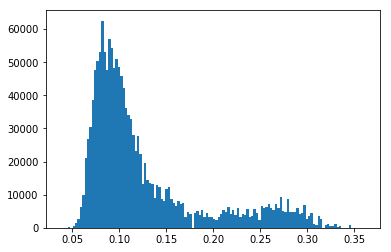

In [62]:
plt.hist(np.concatenate((data[:10000], new_mags_)), bins=128)
plt.show()

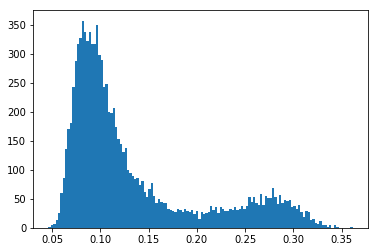

In [61]:
plt.hist(data[:10000], bins=128)
plt.show()